In [1]:
import warnings 
warnings.filterwarnings(action='ignore')

In [2]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from tqdm.auto import tqdm
import cv2

# from tensorflow.keras.applications import Densnet
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
import tensorflow.keras as keras
from tensorflow.data import Dataset

from tensorflow.keras.optimizers import Adam, RMSprop, Nadam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from itertools import product
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import *

2022-06-09 16:49:32.395103: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
tf.__version__

'2.4.1'

In [4]:
IMAGE_SIZE = 320
MODEL_IMAGE_SIZE = 224
SECTION_CLASS_NUM = 8
DISEASE_CLASS_NUM = 4 
GROW_CLASS_NUM = 6 

# Image Load

https://medium.com/analytics-vidhya/write-your-own-custom-data-generator-for-tensorflow-keras-1252b64e41c3

In [5]:
root_dir = '/home/lab38/images'
os.listdir(root_dir)

['로즈마리_해충',
 '딸기_정상_라벨',
 '제라늄_잿빛곰팡이병',
 '상추_해충',
 '딸기_질병_라벨',
 '상추_정상',
 '상추_질병_라벨',
 '딸기_정상_수정본.csv',
 '제라늄_해충',
 '상추_정상_라벨',
 '제라늄_갈색무늬병',
 '딸기_해충',
 '로즈마리_흰가루병',
 '로즈마리_점무늬병',
 '딸기_정상',
 '딸기_질병',
 '상추_질병']

In [6]:
sample_csv = '딸기_정상_수정본.csv'
df = pd.read_csv(os.path.join(root_dir, sample_csv))
df.head()

,image,date,height,width,type,disease,crop,area,grow,risk,points
0,V006_77_0_00_04_01_13_0_b02_20201203_0000_S01_...,2020-12-03,4032,3024,0,0,4,1,13,0,"[{'xtl': 1003, 'ytl': 1167, 'xbr': 2255, 'ybr'..."
1,V006_77_0_00_04_01_13_0_b02_20201203_0001_S01_...,2020-12-03,4032,3024,0,0,4,1,13,0,"[{'xtl': 600, 'ytl': 1087, 'xbr': 1628, 'ybr':..."
2,V006_77_0_00_04_01_13_0_b02_20201203_0002_S01_...,2020-12-03,4032,3024,0,0,4,1,13,0,"[{'xtl': 1003, 'ytl': 1217, 'xbr': 2503, 'ybr'..."
3,V006_77_0_00_04_01_13_0_b02_20201203_0003_S01_...,2020-12-03,4032,3024,0,0,4,1,13,0,"[{'xtl': 662, 'ytl': 1252, 'xbr': 2129, 'ybr':..."
4,V006_77_0_00_04_01_13_0_b02_20201203_0004_S01_...,2020-12-03,4032,3024,0,0,4,1,13,0,"[{'xtl': 370, 'ytl': 884, 'xbr': 1994, 'ybr': ..."


In [7]:
sample_img_path = os.path.join(root_dir, '딸기_정상')
sample_img_path

'/home/lab38/images/딸기_정상'

In [8]:
df['image'] = df['image'].map(lambda x : os.path.join(sample_img_path, x))
df.head()

,image,date,height,width,type,disease,crop,area,grow,risk,points
0,/home/lab38/images/딸기_정상/V006_77_0_00_04_01_13...,2020-12-03,4032,3024,0,0,4,1,13,0,"[{'xtl': 1003, 'ytl': 1167, 'xbr': 2255, 'ybr'..."
1,/home/lab38/images/딸기_정상/V006_77_0_00_04_01_13...,2020-12-03,4032,3024,0,0,4,1,13,0,"[{'xtl': 600, 'ytl': 1087, 'xbr': 1628, 'ybr':..."
2,/home/lab38/images/딸기_정상/V006_77_0_00_04_01_13...,2020-12-03,4032,3024,0,0,4,1,13,0,"[{'xtl': 1003, 'ytl': 1217, 'xbr': 2503, 'ybr'..."
3,/home/lab38/images/딸기_정상/V006_77_0_00_04_01_13...,2020-12-03,4032,3024,0,0,4,1,13,0,"[{'xtl': 662, 'ytl': 1252, 'xbr': 2129, 'ybr':..."
4,/home/lab38/images/딸기_정상/V006_77_0_00_04_01_13...,2020-12-03,4032,3024,0,0,4,1,13,0,"[{'xtl': 370, 'ytl': 884, 'xbr': 1994, 'ybr': ..."


In [9]:
shuffled_df = df.sample(frac=1)

In [10]:
# Train : Validation = 0.8 : 0.2 Split
#train_len = int(len(df)*0.8)

train_df = shuffled_df[:10]
valid_df = shuffled_df[-2:]

train_img_path = train_df['image'].to_list()
train_label = train_df['grow'].to_numpy()

valid_img_path = valid_df['image'].to_list()
valid_label = valid_df['grow'].to_numpy()

In [11]:
train_label.__len__()

10

In [12]:
%%time
train_img = np.array(list(map(cv2.imread, train_img_path)))
valid_img = np.array(list(map(cv2.imread, valid_img_path)))

CPU times: user 1.52 s, sys: 225 ms, total: 1.75 s
Wall time: 1.75 s


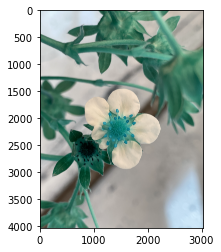

In [13]:
plt.imshow(train_img[0])

In [13]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                 rotation_range=10,
                                 shear_range=0.1,
                                 horizontal_flip=True,
                                 vertical_flip=True,
                                 fill_mode = 'nearest')
test_datagen = ImageDataGenerator(rescale=1./255)

In [14]:
BATCH_SIZE = 2

train_generator = train_datagen.flow(train_img,
                                    train_label,
                                    batch_size=BATCH_SIZE)

# valid_generator = test_datagen.flow(valid_img,
#                                     valid_label,
#                                    batch_size=BATCH_SIZE)

ValueError: setting an array element with a sequence.

In [15]:
img_path = os.listdir(sample_img_path)[0]

In [16]:
img = cv2.imread(os.path.join(sample_img_path, img_path))

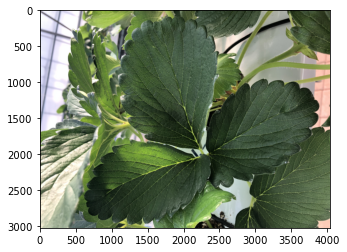

In [17]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [18]:
img = img.astype(np.float32)
img = img /255.

In [19]:
img = cv2.resize(img, (320,320))

In [20]:
img.shape

(320, 320, 3)

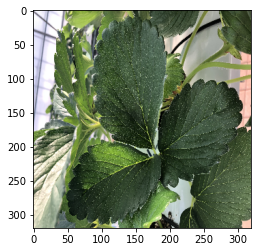

In [21]:
plt.imshow(img)

# Model

In [22]:
tf.keras.backend.clear_session()

In [23]:
base_model= resnet50.ResNet50(
          weights='imagenet',
          include_top=False,
         )


base_model.trainable = False 

2022-06-09 16:50:20.065729: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-06-09 16:50:20.066805: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-06-09 16:50:20.093183: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-09 16:50:20.093736: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2022-06-09 16:50:20.093773: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-06-09 16:50:20.095296: I tensorflow/stream_executor/platform/default/dso_loade

In [24]:
section_inputs = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name='section_inputs')
disease_inputs = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name='disease_inputs')
grow_inputs = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name='grow_inputs')

inputs = layers.concatenate([section_inputs, disease_inputs, grow_inputs])
inputs = layers.Conv2D(3, (3, 3), activation="relu", padding='same')(inputs)
input_model = Model(inputs=[section_inputs, disease_inputs, grow_inputs],
              outputs=inputs)

In [25]:
input_model.outputs

[<KerasTensor: shape=(None, 320, 320, 3) dtype=float32 (created by layer 'conv2d')>]

In [26]:
input_data = layers.Input((IMAGE_SIZE, IMAGE_SIZE, 3))
x = tf.keras.layers.experimental.preprocessing.Resizing(MODEL_IMAGE_SIZE, MODEL_IMAGE_SIZE)(input_data)
resizing = Model(inputs=input_data, outputs=x, name='resize')

In [27]:
x = resizing(input_model.output)
#x = base_model(x, training=False)
x = layers.Conv2D(3, (3,3))(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.BatchNormalization()(x)
backbone_out = layers.Dense(1024, activation='relu')(x)

In [28]:
section_outputs = layers.Dense(SECTION_CLASS_NUM, activation='softmax',
                        name = 'section_outputs')(backbone_out)
disease_outputs = layers.Dense(DISEASE_CLASS_NUM, activation='softmax',
                        name = 'diease_outputs')(backbone_out)
grow_outputs = layers.Dense(GROW_CLASS_NUM, activation='softmax',
                    name = 'grow_outputs')(backbone_out)

model = Model(inputs=[section_inputs, disease_inputs, grow_inputs], 
              outputs=[section_outputs, disease_outputs, grow_outputs],
              name='strawberry_model')

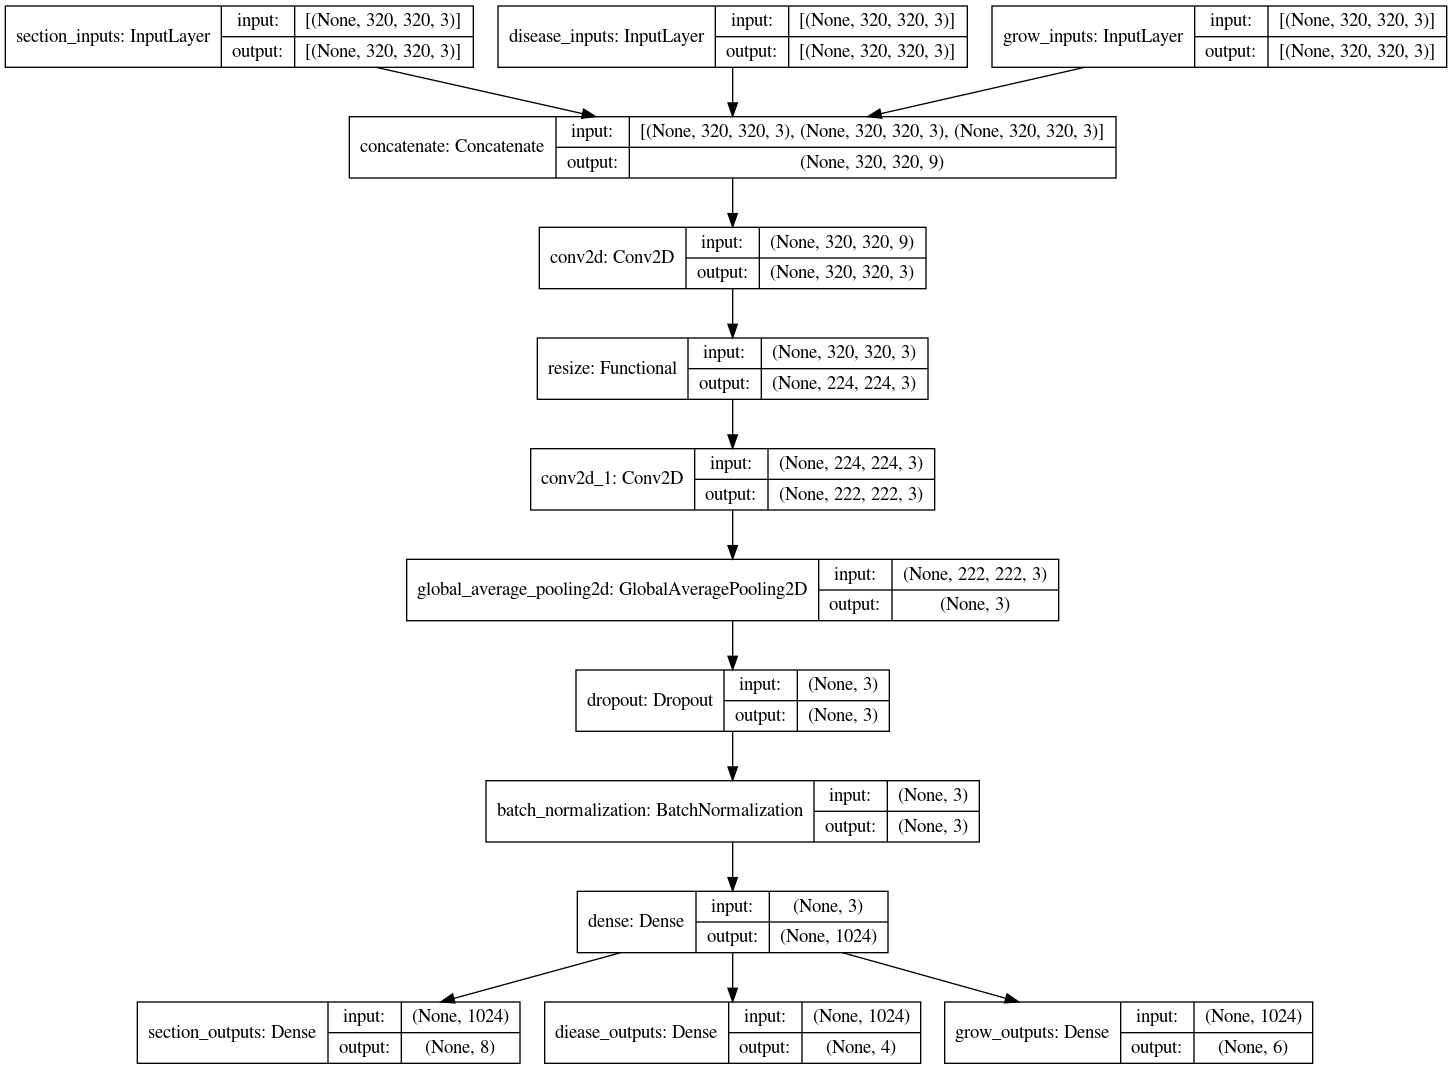

In [30]:
keras.utils.plot_model(model, show_shapes=True)

In [29]:
model.summary()

Model: "strawberry_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
section_inputs (InputLayer)     [(None, 320, 320, 3) 0                                            
__________________________________________________________________________________________________
disease_inputs (InputLayer)     [(None, 320, 320, 3) 0                                            
__________________________________________________________________________________________________
grow_inputs (InputLayer)        [(None, 320, 320, 3) 0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 320, 320, 9)  0           section_inputs[0][0]             
                                                                 disease_inputs[0][

In [30]:
model.compile(loss={
                  'section_outputs' : 'sparse_categorical_crossentropy',
                  'diease_outputs' : 'sparse_categorical_crossentropy',
                  'grow_outputs' : 'sparse_categorical_crossentropy'
              },
              optimizer=Adam(learning_rate=1e-4),
              metrics=['accuracy']) # 필요시 f1 score metrics custom

In [31]:
img.shape

(320, 320, 3)

In [32]:
img = np.array([img])
s = np.array([0])
d = np.array([0])
g = np.array([0])
img_dataset = tf.data.Dataset.from_tensor_slices(img)

In [33]:
img_dataset

<TensorSliceDataset shapes: (320, 320, 3), types: tf.float32>

In [34]:
model.fit({'section_inputs':img, 'disease_inputs':img, 'grow_inputs':img},
         {'section_outputs': s, 'diease_outputs':d, 'grow_outputs':g},
         epochs=1)

2022-06-09 16:50:59.262969: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-06-09 16:50:59.282944: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2499995000 Hz
2022-06-09 16:51:00.053555: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-06-09 16:51:00.335559: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


1/1 [==============================] - 2s 2s/step - loss: 5.2575 - section_outputs_loss: 2.0794 - diease_outputs_loss: 1.3863 - grow_outputs_loss: 1.7918 - section_outputs_accuracy: 1.0000 - diease_outputs_accuracy: 1.0000 - grow_outputs_accuracy: 1.0000


# Other Way

In [40]:
inputs = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
x = resizing(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.BatchNormalization()(x)
backbone_out = layers.Dense(1024, activation='softmax')(x)


section_outputs = layers.Dense(SECTION_CLASS_NUM, activation='softmax',
                        name = 'section_outputs')(backbone_out)
disease_outputs = layers.Dense(DISEASE_CLASS_NUM, activation='softmax',
                        name = 'diease_outputs')(backbone_out)
grow_outputs = layers.Dense(GROW_CLASS_NUM, activation='softmax',
                    name = 'grow_outputs')(backbone_out)

model = Model(inputs=inputs, 
              outputs=[section_outputs, disease_outputs, grow_outputs],
              name='strawberry')

In [41]:
model.summary()

Model: "strawberry"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 320, 320, 3) 0                                            
__________________________________________________________________________________________________
resize (Functional)             (None, 224, 224, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
resnet50 (Functional)           (None, None, None, 2 23587712    resize[2][0]                     
__________________________________________________________________________________________________
global_average_pooling2d_2 (Glo (None, 2048)         0           resnet50[1][0]                   
_________________________________________________________________________________________

In [42]:
model.compile(loss={
                  'section_outputs' : 'sparse_categorical_crossentropy',
                  'diease_outputs' : 'sparse_categorical_crossentropy',
                  'grow_outputs' : 'sparse_categorical_crossentropy'
              },
              optimizer=Adam(learning_rate=1e-4),
              metrics=['accuracy']) # 필요시 f1 score metrics custom

In [43]:
model.fit(img,
         {'section_outputs': s, 'diease_outputs':d, 'grow_outputs':g},
         epochs=1)

1/1 [==============================] - 3s 3s/step - loss: 5.2561 - section_outputs_loss: 2.0775 - diease_outputs_loss: 1.3856 - grow_outputs_loss: 1.7929 - section_outputs_accuracy: 0.0000e+00 - diease_outputs_accuracy: 0.0000e+00 - grow_outputs_accuracy: 0.0000e+00
